In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import logm, expm

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)


# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

In [3]:
## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled


## Now we want to move the grid so it lies in the first quadrant 

# We check how much it should be moved along postive x axis and y axis
x_move = min(xs_scaled)
y_move = min(ys_scaled)

# Add the absolute to every coordinate
xs_final = [x + abs(x_move) for x in xs_scaled]
ys_final = [y + abs(y_move) for y in ys_scaled]
grid_final = [(x,y) for x, y in zip(xs_final, ys_final)]

jump_final = []
for i in jump_scaled:
    xs_temp = [j[0] + abs(x_move) for j in i]
    ys_temp = [j[1] + abs(y_move) for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_final.append(jump_temp)


# The new vertices are stored in grid_final
# The new jumps are stored in jump_final

In [4]:
## DEFINITION OF USEFUL FUNCTIONS

def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(k[1] - i[1]) * (i[0] + k[0]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs


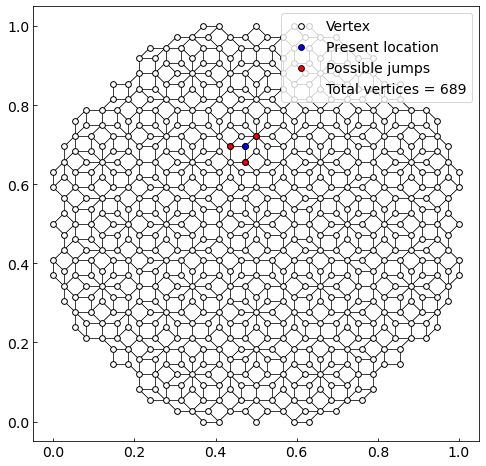

In [5]:
# Define figure
fig, ax = plt.subplots(figsize=(8,8))

# Plot all possible paths between vertices
for i,j in zip(grid_final, jump_final):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)


# Choose index to highlight a specific vertex and its connecting points
#ind_choice = int(len(z)*0.33)
ind_choice = 340

xs_jumps = [w[0] for w in jump_final[ind_choice]]
ys_jumps = [w[1] for w in jump_final[ind_choice]]

marker_size = 33

ax.scatter(x= xs_final, y= ys_final, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1)
ax.scatter(x= xs_final[ind_choice], y= ys_final[ind_choice], s= marker_size, facecolor= 'b', edgecolor= 'k', label= "Present location", linewidth= 1)
ax.scatter(x= xs_jumps, y= ys_jumps, s= marker_size, facecolor= 'r', edgecolor= 'k', label= "Possible jumps", linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(grid_coordinates)))

ax.legend(loc= 1)

# IF YOU WANT TO SAVE IT. NAME IS IDENTICAL TO THAT OF OTHER AB TILING FILE
#plt.savefig('../Illustrations/hofstadter_AB_tiling.png')
plt.show()

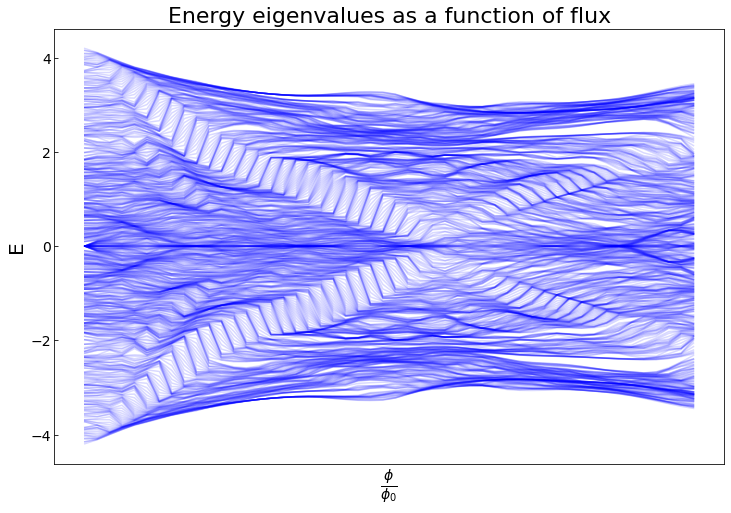

In [6]:
# We want to know when phi/phi0 = 1, this happens when phi = 2pi
# phi in this case is phi = B*l*2 so B must be equal to
B_full = (2*np.pi)/(0.03825242185233838**2)

# Calculate eigenvalues for varying B field strength
Bs = np.linspace(0,B_full,50)
eigvals = [Hamil_solve(grid_final,jump_final,x)[0] for x in Bs]
# Segment the eigenvalues into proper drawable bands
dim_H = len(jump_final)
bands = [x for x in range(0, dim_H)]

eigs_banded = []
for i in bands:
    band = [x[i] for x in eigvals]
    eigs_banded.append(band)

# Plot the figure of bands by separating into separate bands and plotting
fig, ax = plt.subplots(figsize= (12,8))

for y in eigs_banded:
    ax.plot(Bs,y, color= 'b', alpha= 0.15)

ax.set_title('Energy eigenvalues as a function of flux')
ax.set_xlabel(r'$\frac{\phi}{\phi_0}$')
ax.set_ylabel(r'E')
ax.set_xticks([])

#plt.savefig('../Illustrations/AB_bands.png')
plt.show()